In [1]:
import straug
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [61]:
import random
import cv2
import albumentations as A
import numpy as np

# class geometry flip,rotate,perspective

class geometry:
    def __init__(self):
        
        # self.degree = random.randint(1, 30)
        pass

    """
    def rotate(self, image, bbox):
        h, w, c = image.shape
        cx, cy = w / 2, h / 2
    """
        
    def hflip(self, image, bbox):
        transform = A.HorizontalFlip(p=1)
        length = len(bbox)
        width = image.shape[1]
        new_box = np.zeros((length, 4, 2))
        for i in range(length):
            for j in range(4):
                new_box[i][j][0] = width - bbox[i][j][0]
                new_box[i][j][1] = bbox[i][j][1]
        return transform(image=image)["image"], new_box

    
    def vflip(self, image, bbox):
        transform = A.VerticalFlip(p=1)
        length = len(bbox)
        height = image.shape[0]
        new_box = np.zeros((length, 4, 2))
        for i in range(length):
            for j in range(4):
                new_box[i][j][1] = height - bbox[i][j][1]
                new_box[i][j][0] = bbox[i][j][0]
        return transform(image=image)["image"], new_box
    
    def __call__(self, image, bbox):
        print(image.shape)
        transform = random.sample([self.hflip, self.vflip], 1)[0]
        return transform(image, bbox)



class noise:
    def __init__(self):
        self.transform = A.OneOf(
            [
                A.GaussNoise(p=1),
            ],
            p=1,
        )

    def __call__(self, image):
        return self.transform(image=image)["image"]


class blur:
    def __init__(self):
        self.transform = A.OneOf(
            [
                #A.GaussianBlur(p=1),
                A.MotionBlur(p=1),
                #A.Defocus(p=1),
                #A.GlassBlur(p=1, max_delta=1, iterations=1),
            ],
            p=1,
        )

    def __call__(self, image):
        return self.transform(image=image)["image"]


class weather:
    def __init__(self):
        self.transform = A.OneOf(
            [
                A.RandomRain(p=1),
                #A.RandomSnow(p=1),
                A.RandomFog(p=1),
                A.RandomShadow(p=1),
            ],
            p=1,
        )

    def __call__(self, image):
        return self.transform(image=image)["image"]


class camera:
    def __init__(self):
        self.transform = A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.JpegCompression(p=1),
            ],
            p=1,
        )

    def __call__(self, image):
        return self.transform(image=image)["image"]


class process:
    def __init__(self):
        self.transform = A.OneOf(
            [
                A.Posterize(p=1),
                A.Equalize(p=1),
                A.Solarize(p=1),
                A.InvertImg(p=1),
            ],
            p=1,
        )

    def __call__(self, image):
        return self.transform(image=image)["image"]


class augment:
    def __init__(self, img_size):
        self.img_size = img_size
        self.geometry = geometry()
        self.blur = blur()
        self.noise = noise()
        self.weather = weather()
        self.camera = camera()
        self.process = process()

    def _resize(self, img: np.array, annotation):
        h, w, _ = img.shape
        size=self.img_size
        ratio = size / max(h, w)
        if w > h:
            img = A.Resize(int(h*ratio),size)(image=img)["image"]
            #img = img.resize((size, int(h * ratio)), Image.BILINEAR)
        else:
            img = A.Resize(size,(int(w*ratio)))(image=img)["image"]
            #img = img.resize((int(w * ratio), size), Image.BILINEAR)
        for ann in annotation:
            for pts in ann:
                pts[0]*=ratio
                pts[1]*=ratio
        return img,annotation


    def __call__(self, img, annotation, label):
        transform_list = random.sample(
            [
                self.geometry,
                self.blur,
                self.noise,
                self.weather,
                self.camera,
                self.process,
            ],
            2,
        )
        for transform in transform_list:
            print(transform)
            if transform == self.geometry:
                img, annotation = transform(img, annotation)
            else:
                img = transform(img)
        img, annotation = self._resize(img, annotation)
        # geometry적용시 bbox, annotation 변경
        return dict(img=img, annotation=annotation, label=label)


# Rotate

# Perpective

# Distort

#


In [66]:
img=cv2.imread('/opt/ml/input/data/ICDAR17_Korean/images/img_992.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
transform=augment(1024)
bboxes=[[[529.0, 1841.0], [1980.0, 1833.0], [1997.0, 2051.0], [545.0, 2058.0]],
        [[553.0, 2085.0], [883.0, 2084.0], [890.0, 2206.0], [564.0, 2203.0]],
        [[937.0, 2080.0], [1992.0, 2076.0], [1989.0, 2204.0], [972.0, 2217.0]]]

res=transform(img,bboxes,[])
img=res['img']
bboxes=res['annotation']
bboxes=np.array(bboxes,dtype=np.int32)

for bbox in bboxes:

      img = cv2.polylines(img, [bbox], True, (255, 0, 0), 3)

(2268, 3024, 3)


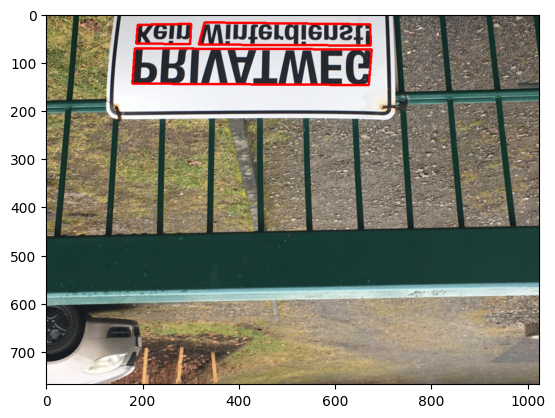

In [67]:
plt.imshow(img)